<center> <h1> Generative Adversarial Networks and Cycle-GAN <h1> <center>

# Introduction

Ce notebook a été réalisé par Christos Katsoulakis et Eric Lavergne dans le cadre d'un projet pour le cours "Deep Learning: Models and Optimization" de l'Ensae Paris. Nous nous sommes intéressés à plusieurs variantes des Generative Adversarial Networks (GANs) pour la génération d'images: le Deep Convolutional Generative Adversarial Networks (DCGAN) et le Wasserstein GAN (WGAN). Ensuite nous avons étudié le Cycle GAN pour la translation d'image d'un domaine à un autre.

### Imports

Le framework PyTorch est utilisé pour l'implémentation de ce projet.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### Sélection de l'équipement d'exécution

Nous utilisons un GPU pour accélérer l'exécution des calculs.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Downloading and preprocessing data

Dans cette partie nous procédons aux téléchargements et aux traitements des données. 

Les données sont des images issues des bases de données MNIST et USPS, puis des données de visage avec caractéristiques CelebA.

Les principaux traitements consistent à redimensionner la taille des images et à mettre les valeurs des pixels sur l'échelle [-1,1] (le type de fonction d'activation utilisée en sortie du générateur est une tangente hyperbolique à valeur dans [-1,1]).

### MNIST data

In [ ]:
# Chargement des données MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Dimension des données
print("mnist_trainset shape:", mnist_trainset.data.shape)
print("mnist_testset shape:", mnist_testset.data.shape)

mnist_trainset shape: torch.Size([60000, 28, 28])
mnist_testset shape: torch.Size([10000, 28, 28])


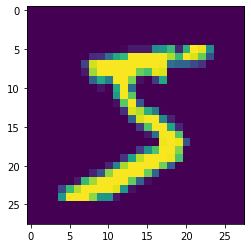

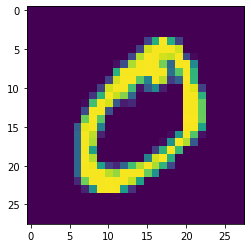

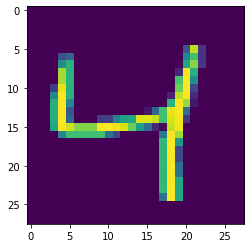

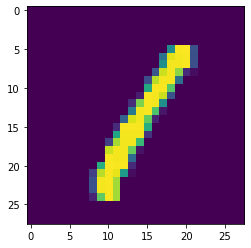

In [ ]:
# Affichage de quelques images
for i in range(4):
    plt.imshow(mnist_trainset.data[i])
    plt.show()

In [ ]:
# Traitement des données
def prepare_mnist(mnist_dataset):
    mnist_data = torch.tensor(mnist_dataset.data, dtype=torch.float)
    mnist_data = torch.unsqueeze(mnist_data, 1)
    mnist_data = nn.functional.interpolate(mnist_data, size=(32,32), mode='bilinear', align_corners=True)
    mnist_data = 2*(mnist_data / torch.max(mnist_data)) - 1
    return mnist_data

mnist_data_train = prepare_mnist(mnist_trainset)
mnist_data_test = prepare_mnist(mnist_testset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Dimension des données après traitements
print("mnist_data_train shape:", mnist_data_train.shape)
print("mnist_data_test shape:", mnist_data_test.shape)

mnist_data_train shape: torch.Size([60000, 1, 32, 32])
mnist_data_test shape: torch.Size([10000, 1, 32, 32])


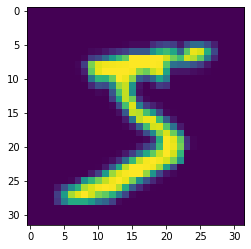

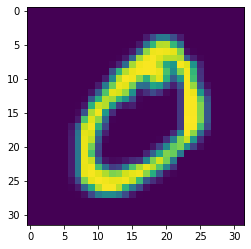

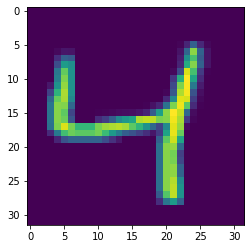

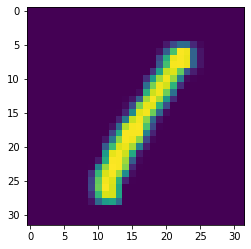

In [ ]:
# Affichage de quelques images après traitements
for i in range(4):
    plt.imshow(mnist_data_train[i][0])
    plt.show()

### USPS data (handwritten digits)

In [ ]:
# Chargement des données USPS
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=None)
usps_testset = datasets.USPS(root='./data', train=False, download=True, transform=None)

In [ ]:
# Dimension des données
print("usps_trainset shape:", usps_trainset.data.shape)
print("usps_testset shape:", usps_testset.data.shape)

usps_trainset shape: (7291, 16, 16)
usps_testset shape: (2007, 16, 16)


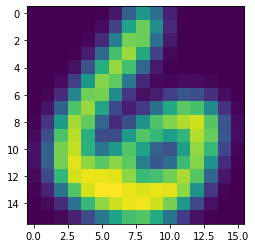

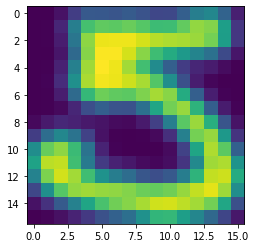

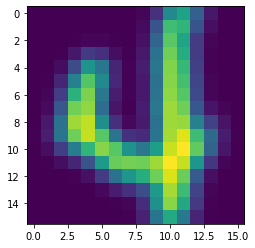

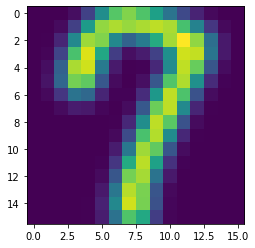

In [ ]:
# Affichage de quelques images
for i in range(4):
    plt.imshow(usps_trainset.data[i])
    plt.show()

In [ ]:
# Traitement des données
def prepare_usps(usps_dataset):
    usps_data = torch.tensor(usps_dataset.data, dtype=torch.float)
    usps_data = torch.unsqueeze(usps_data, 1)
    usps_data = nn.functional.interpolate(usps_data, size=(32,32), mode='bilinear', align_corners=True)
    usps_data = 2*(usps_data / torch.max(usps_data)) - 1
    return usps_data


usps_data_train = prepare_usps(usps_trainset)
usps_data_test = prepare_usps(usps_testset)

In [ ]:
# Dimension des données après traitements
print("usps_data_train shape:", usps_data_train.shape)
print("usps_data_test shape:", usps_data_test.shape)

usps_data_train shape: torch.Size([7291, 1, 32, 32])
usps_data_test shape: torch.Size([2007, 1, 32, 32])


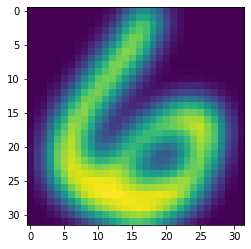

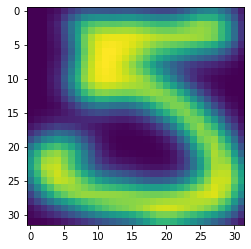

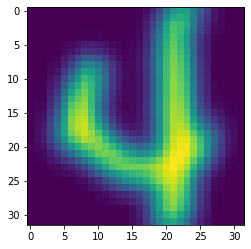

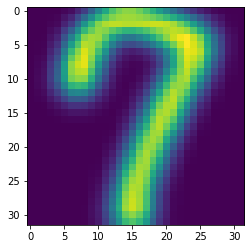

In [ ]:
# Affichage de quelques images après traitements
for i in range(4):
    plt.imshow(usps_data_train[i][0])
    plt.show()

### CelebA data (faces images)

Au vu de la taille du dataset, seul un sous-ensemble de données a été importé dans un répertoire sur Google Drive puis lié à l'environnement de Google Colab. 

Les données sont téléchargeables au lien suivant : https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?usp=drive_open

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/DL_Project_ENSAE/img_align_celeba_50000.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_align_celeba_50000/faces/045001.jpg  
  inflating: img_align_celeba_50000/faces/045002.jpg  
  inflating: img_align_celeba_50000/faces/045003.jpg  
  inflating: img_align_celeba_50000/faces/045004.jpg  
  inflating: img_align_celeba_50000/faces/045005.jpg  
  inflating: img_align_celeba_50000/faces/045006.jpg  
  inflating: img_align_celeba_50000/faces/045007.jpg  
  inflating: img_align_celeba_50000/faces/045008.jpg  
  inflating: img_align_celeba_50000/faces/045009.jpg  
  inflating: img_align_celeba_50000/faces/045010.jpg  
  inflating: img_align_celeba_50000/faces/045011.jpg  
  inflating: img_align_celeba_50000/faces/045012.jpg  
  inflating: img_align_celeba_50000/faces/045013.jpg  
  inflating: img_align_celeba_50000/faces/045014.jpg  
  inflating: img_align_celeba_50000/faces/045015.jpg  
  inflating: img_align_celeba_50000/faces/045016.jpg  
  inflating: img_align_celeba_50000/faces/

In [ ]:
# Répertoire central pour les données
data_root = 'img_align_celeba_50000'

# Redimensionnement des images à la taille image_size
image_size = 64

dataset_faces = datasets.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ]))

In [ ]:
dataset_faces

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: img_align_celeba_50000
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
           )

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 8417
    Root location: /content/drive/MyDrive/DL_Project_ENSAE/img_align_celeba_reshaped64_mustache_split/no_mustache_repo
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
           )

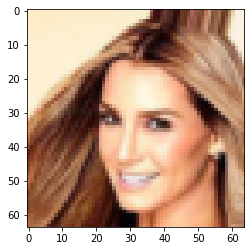

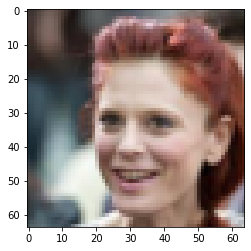

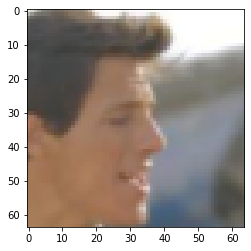

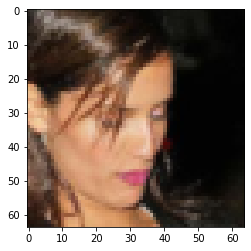

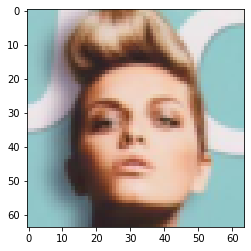

In [ ]:
# Affichages de quelques images du dataset
for i in range(5):
    plt.imshow((dataset_faces[i][0]).permute(1,2,0))
    plt.show()

### CelebA black/blond hair split (faces images with hair color labels)

On sélectionn des images ayant la caractéristique black_hair et blond_hair afin de faire du transfert de style. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/DL_Project_ENSAE/hair_repo/black_hair.zip'
!unzip '/content/drive/MyDrive/DL_Project_ENSAE/hair_repo/blond_hair.zip'
!mkdir "black_hair_repo"
!mkdir "blond_hair_repo"
!mv "black_hair" "black_hair_repo/black_hair"
!mv "blond_hair" "blond_hair_repo/blond_hair"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: blond_hair/000019.jpg   
  inflating: blond_hair/000022.jpg   
  inflating: blond_hair/000024.jpg   
  inflating: blond_hair/000029.jpg   
  inflating: blond_hair/000054.jpg   
  inflating: blond_hair/000071.jpg   
  inflating: blond_hair/000092.jpg   
  inflating: blond_hair/000094.jpg   
  inflating: blond_hair/000100.jpg   
  inflating: blond_hair/000108.jpg   
  inflating: blond_hair/000111.jpg   
  inflating: blond_hair/000112.jpg   
  inflating: blond_hair/000122.jpg   
  inflating: blond_hair/000126.jpg   
  inflating: blond_hair/000133.jpg   
  inflating: blond_hair/000140.jpg   
  inflating: blond_hair/000141.jpg   
  inflating: blond_hair/000147.jpg   
  inflating: blond_hair/000152.jpg   
  inflating: blond_hair/000156.jpg   
  inflating: blond_hair/000157.jpg   
  inflating: blond_hair/000167.jpg   
  inflating: blond_hair/000178.jpg   
  inflating: blond_hair/000191.jpg   
  inflatin

In [ ]:
#black hair
data_root = 'black_hair_repo'
image_size = 64

dataset_black_hair = datasets.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ]))

In [ ]:
#blond hair
data_root = 'blond_hair_repo'
image_size = 64

dataset_blond_hair = datasets.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ]))

In [ ]:
# Informations sur les données black_hair
dataset_black_hair

Dataset ImageFolder
    Number of datapoints: 5000
    Root location: black_hair_repo
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
           )

In [ ]:
# Informations sur les données blond_hair
dataset_blond_hair

Dataset ImageFolder
    Number of datapoints: 5000
    Root location: blond_hair_repo
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
           )

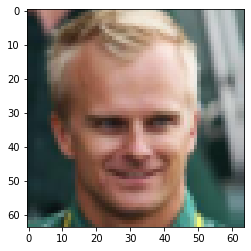

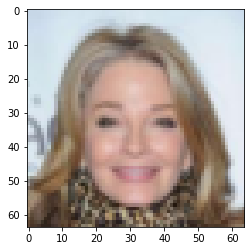

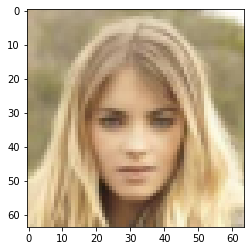

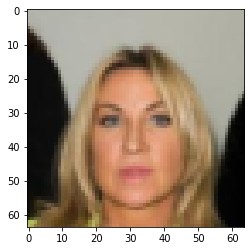

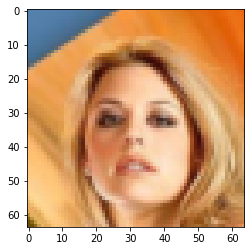

In [ ]:
# Affichages de données ayant la caractéristique blond_hair
for i in range(5):
    plt.imshow(dataset_blond_hair[i][0].permute(1,2,0))
    plt.show()

# Utils

Dans cette partie nous définissons des fonctions utilitaires pour le projet.

generate_and_show est une fonction permettant de générer et d'afficher "nb_generated" images étant donné le générateur "generator" donné en entrée.

In [ ]:
def generate_and_show(generator, nb_generated, celeba_data=False):
    batch_noise_fake = torch.randn(batch_size, 100) * 0.1
    batch_noise_fake = batch_noise_fake.to(device)
    batch_data_fake = generator(batch_noise_fake)
    for data_fake in batch_data_fake:
        if celeba_data:
            data_fake = (1 + data_fake)/2
            plt.imshow(data_fake.permute(1,2,0).cpu().detach().numpy())
            plt.show()
        else:
            plt.imshow(data_fake.view(32,32).cpu().detach().numpy())
            plt.show()

# DCGAN

Dans cette partie nous définissons le modèle Deep Convolutional Generative Adversarial Networks (DCGAN) puis effectuons de la génération d'image sur le jeu de données MNIST et CelebA.

### Model

In [ ]:
class DCGAN_discriminator(nn.Module):

    def __init__(self, image_depth=1, image_size=32):

        super(DCGAN_discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=image_depth, out_channels=32, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(in_features=(image_size//8)*(image_size//8)*128, out_features=1)

    def init_weight(self):
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.02)

        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
class DCGAN_generator(nn.Module):

    def __init__(self, image_depth=1, image_size=32):
        
        super(DCGAN_generator, self).__init__()

        self.image_size = image_size
        self.fc1 = nn.Linear(100, (self.image_size//8)*(self.image_size//8)*128)
        self.bn1 = nn.BatchNorm2d(128)

        self.up2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, 
                               kernel_size=5, stride=1, 
                               padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.up3 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, 
                               kernel_size=5, stride=1, 
                               padding=2)
        self.bn3 = nn.BatchNorm2d(32)

        self.up4 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=image_depth, 
                               kernel_size=5, stride=1, 
                               padding=2)

    def init_weight(self):
        nn.init.normal_(self.conv4.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.02)
    
    def forward(self, x):

        x = self.fc1(x)
        x = x.view(x.shape[0], 128, (self.image_size//8), (self.image_size//8))
        x = self.bn1(x)
        x = F.relu(x)

        x = self.up2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.up3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.up4(x)
        x = self.conv4(x)
        x = torch.tanh(x)

        return x

In [ ]:
def discriminator_loss(discriminator, batch_data_real, batch_data_fake, batch_size):
    first_term = (1/(2*batch_size)) * ((discriminator(batch_data_real)-1)**2).sum() 
    second_term = (1/(2*batch_size)) * (discriminator(batch_data_fake)**2).sum()
    return first_term + second_term

def generator_loss(discriminator, batch_data_fake, batch_size):
    return (1/(batch_size)) * ((discriminator(batch_data_fake) - 1)**2).sum()

In [ ]:
def DCGAN_train(data_loader, discriminator, generator, batch_size, nb_epochs, show=False, celeba_data=False):

    optimizer_discriminator = optim.Adam(discriminator.parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999))
    optimizer_generator = optim.Adam(generator.parameters(),
                                     lr=0.0002, betas=(0.5, 0.999))
    
    loss_discriminator_list = []

    discriminator.init_weight()
    generator.init_weight()

    
    for epoch in tqdm(range(nb_epochs)):

        for batch_data_real in data_loader:

            if celeba_data:
                batch_data_real = 2*batch_data_real[0] - 1
            batch_data_real = batch_data_real.to(device)

            # Discriminator

            optimizer_discriminator.zero_grad()

            batch_noise_fake = torch.randn(batch_size, 100) * 0.1
            batch_noise_fake = batch_noise_fake.to(device)
            batch_data_fake = generator.forward(batch_noise_fake)
            loss_discriminator = discriminator_loss(discriminator, batch_data_real, 
                                                    batch_data_fake, batch_size)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # Generator

            optimizer_generator.zero_grad()
            
            batch_noise_fake = torch.randn(batch_size, 100) * 0.1 
            batch_noise_fake = batch_noise_fake.to(device)
            batch_data_fake = generator.forward(batch_noise_fake)
            loss_generator = generator_loss(discriminator, batch_data_fake, batch_size)

            loss_generator.backward()
            optimizer_generator.step()

            loss_discriminator_list.append(loss_discriminator)

        if show:
            print("\n\nEpoch : {} ---".format(epoch))
            generate_and_show(dcgan_generator, 3, celeba_data=celeba_data)

    plt.plot(range(1, len(loss_discriminator_list)+1), loss_discriminator_list)
    plt.xlabel("generator iterations")
    plt.ylabel("discriminator loss")
    plt.title("Discriminator loss evolution for DCGAN")
    plt.show()


### Experiment MNIST

In [ ]:
# Configuration de l'apprentissage
nb_epochs = 15
batch_size = 64
nb_data_train = 60000
nb_data_test = 1000

In [ ]:
# DataLoader
train_loader_mnist = DataLoader(mnist_data_train[:nb_data_train,:,:,:], batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(mnist_data_test[:nb_data_test,:,:,:], batch_size=batch_size, shuffle=True)

In [ ]:
# Discriminateur
dcgan_discriminator = DCGAN_discriminator(image_depth=1)
dcgan_discriminator.to(device)

# Generateur
dcgan_generator = DCGAN_generator(image_depth=1)
dcgan_generator.to(device)

DCGAN_generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up3): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up4): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


  0%|          | 0/15 [00:00<?, ?it/s]



Epoch : 0 ---


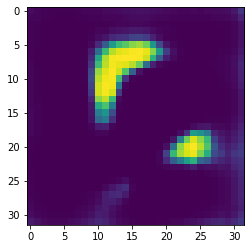

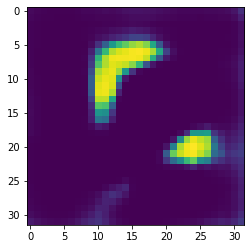

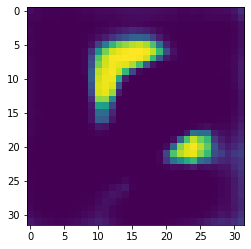


  7%|▋         | 1/15 [00:14<03:20, 14.34s/it]



Epoch : 1 ---


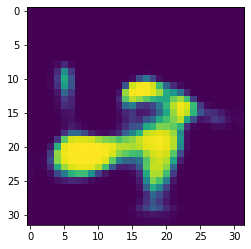

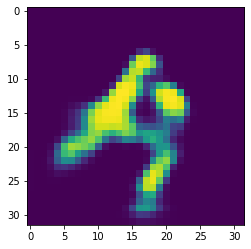

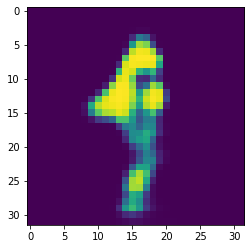


 13%|█▎        | 2/15 [00:28<03:06, 14.33s/it]



Epoch : 2 ---


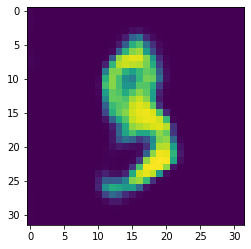

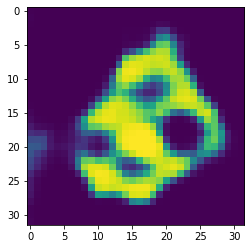

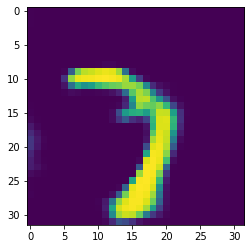


 20%|██        | 3/15 [00:42<02:51, 14.33s/it]



Epoch : 3 ---


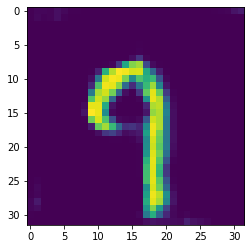

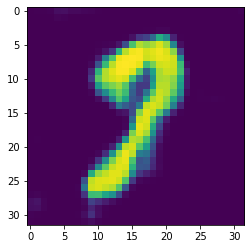

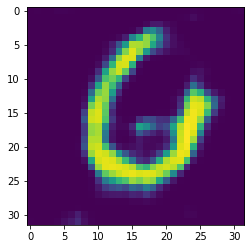


 27%|██▋       | 4/15 [00:57<02:37, 14.36s/it]



Epoch : 4 ---


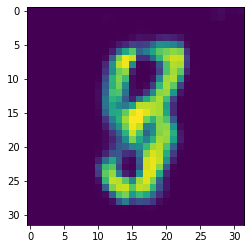

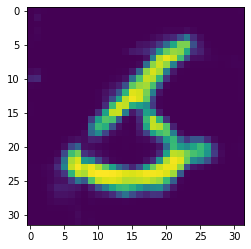

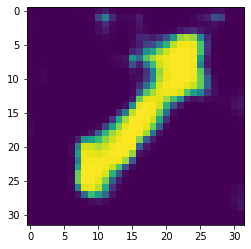


 33%|███▎      | 5/15 [01:11<02:23, 14.35s/it]



Epoch : 5 ---


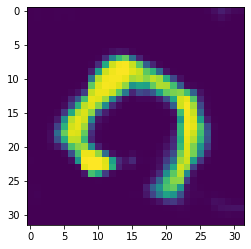

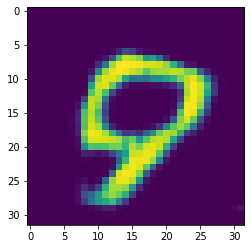

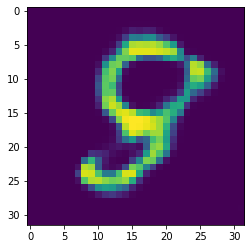


 40%|████      | 6/15 [01:26<02:08, 14.33s/it]



Epoch : 6 ---


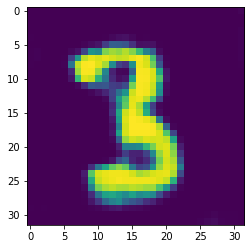

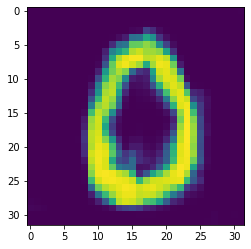

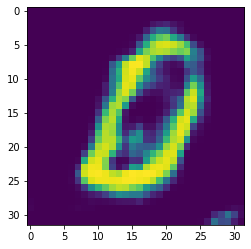


 47%|████▋     | 7/15 [01:40<01:54, 14.33s/it]



Epoch : 7 ---


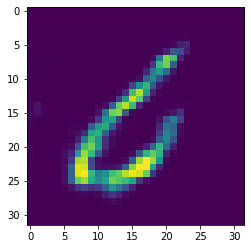

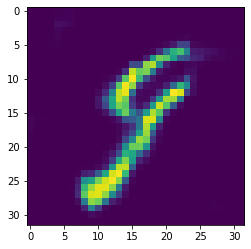

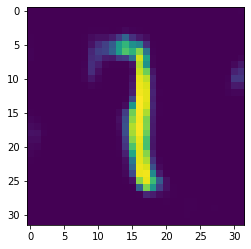


 53%|█████▎    | 8/15 [01:54<01:40, 14.34s/it]



Epoch : 8 ---


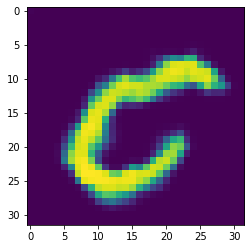

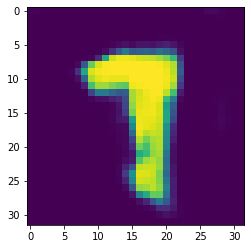

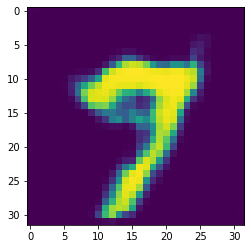


 60%|██████    | 9/15 [02:09<01:26, 14.36s/it]



Epoch : 9 ---


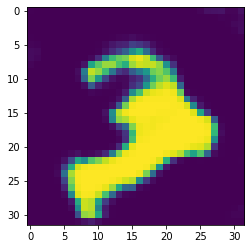

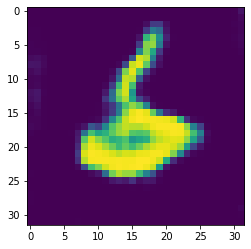

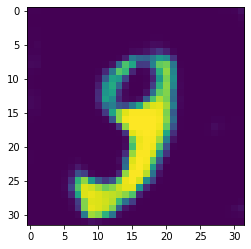


 67%|██████▋   | 10/15 [02:23<01:11, 14.35s/it]



Epoch : 10 ---


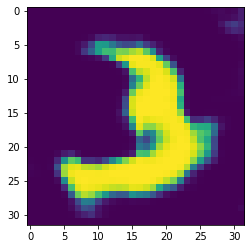

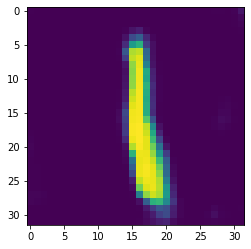

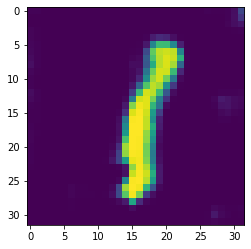


 73%|███████▎  | 11/15 [02:37<00:57, 14.34s/it]



Epoch : 11 ---


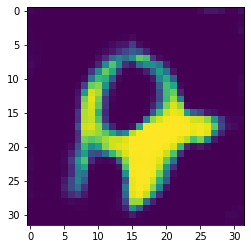

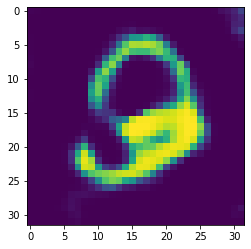

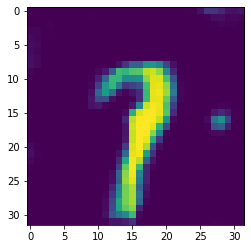


 80%|████████  | 12/15 [02:52<00:42, 14.32s/it]



Epoch : 12 ---


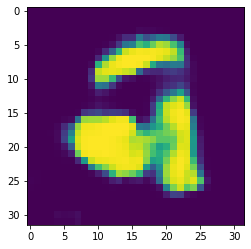

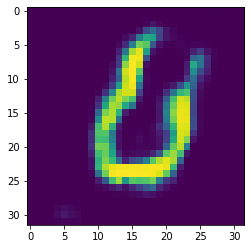

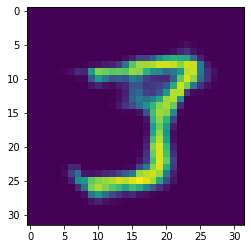


 87%|████████▋ | 13/15 [03:06<00:28, 14.32s/it]



Epoch : 13 ---


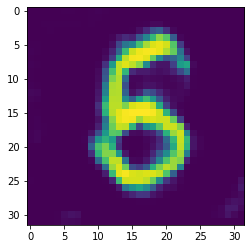

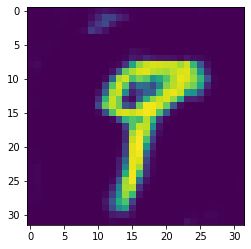

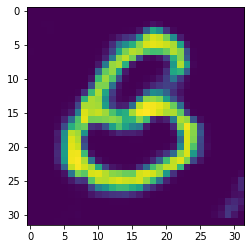


 93%|█████████▎| 14/15 [03:20<00:14, 14.36s/it]



Epoch : 14 ---


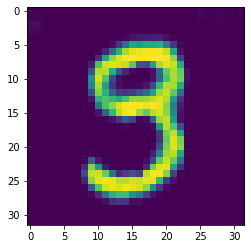

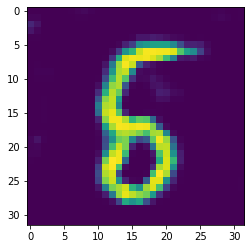

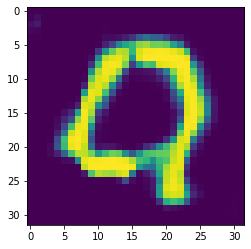


100%|██████████| 15/15 [03:35<00:00, 14.34s/it]


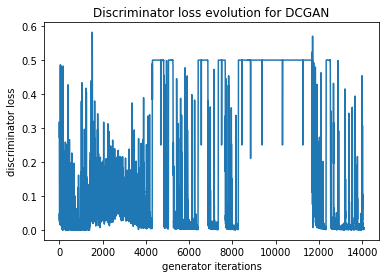

In [ ]:
# Apprentissage
DCGAN_train(train_loader_mnist, dcgan_discriminator, dcgan_generator, batch_size, nb_epochs, show=True)

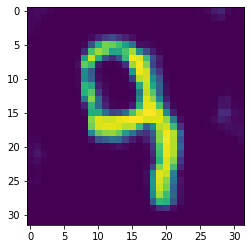

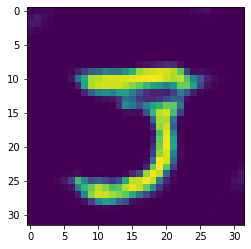

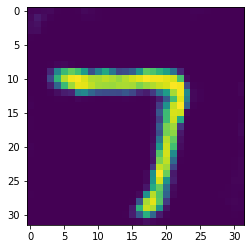

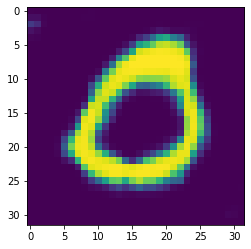

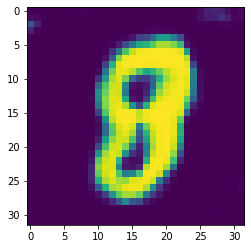

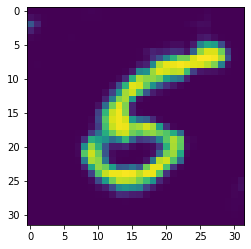

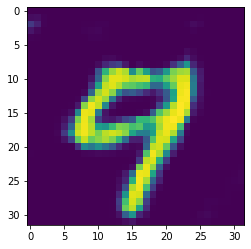

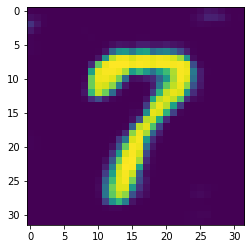

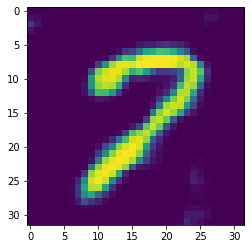

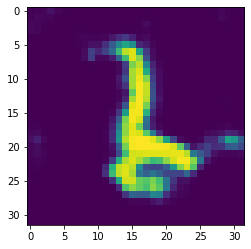

In [ ]:
# Génération d'images
generate_and_show(dcgan_generator, 10)

In [ ]:
# Prédictions du discriminateur sur des données réelles
dcgan_discriminator(mnist_data_train[:10,:,:,:].to(device))

tensor([[0.8953],
        [0.9397],
        [0.9519],
        [0.9371],
        [0.9220],
        [0.9699],
        [0.9836],
        [0.9867],
        [0.8642],
        [0.9695]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
# Prédictions du discriminateur sur des données générées
batch_noise_fake = torch.randn(10, 100) * 0.1
batch_noise_fake = batch_noise_fake.to(device)
batch_data_fake = dcgan_generator(batch_noise_fake)
dcgan_discriminator(batch_data_fake[:10,:,:,:].to(device))

tensor([[0.0047],
        [0.0053],
        [0.0026],
        [0.0015],
        [0.0022],
        [0.0004],
        [0.0070],
        [0.0024],
        [0.0075],
        [0.0027]], device='cuda:0', grad_fn=<SigmoidBackward>)

### Experiment CelebA

In [ ]:
# Configuration de l'apprentissage
nb_epochs = 30
batch_size = 32

In [ ]:
# DataLoader
train_loader = DataLoader(dataset_faces, batch_size=batch_size, shuffle=True)

In [ ]:
# Discriminateur
discriminator = DCGAN_discriminator(image_depth=3, image_size=64)
discriminator.to(device)

# Générateur
generator = DCGAN_generator(image_depth=3, image_size=64)
generator.to(device)

DCGAN_generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up3): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up4): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


  0%|          | 0/30 [00:00<?, ?it/s]



Epoch : 0 ---


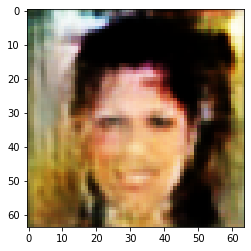

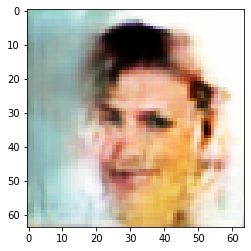

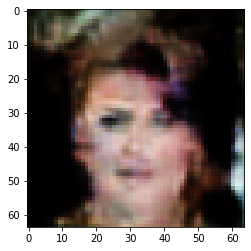


  3%|▎         | 1/30 [01:31<44:14, 91.55s/it]



Epoch : 1 ---


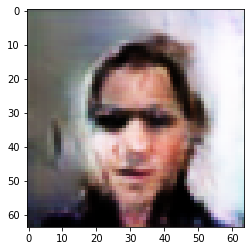

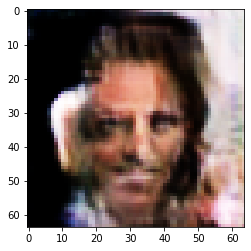

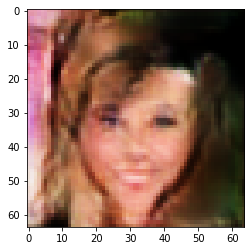


  7%|▋         | 2/30 [03:02<42:42, 91.51s/it]



Epoch : 2 ---


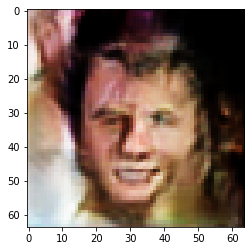

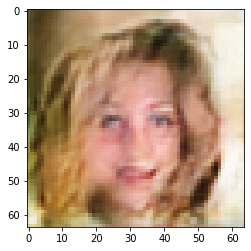

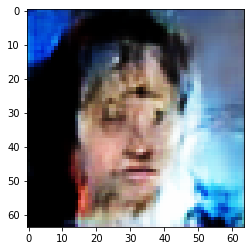


 10%|█         | 3/30 [04:34<41:07, 91.40s/it]



Epoch : 3 ---


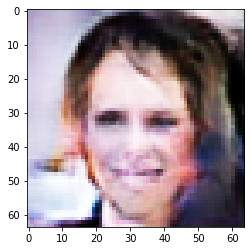

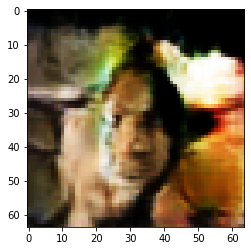

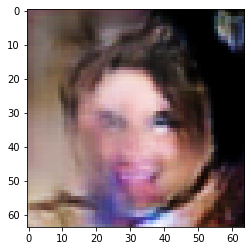


 13%|█▎        | 4/30 [06:06<39:44, 91.72s/it]



Epoch : 4 ---


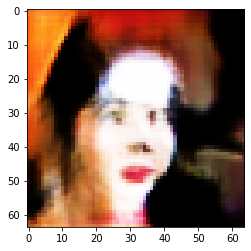

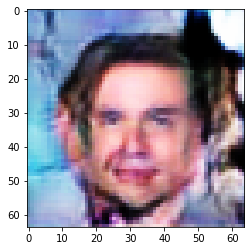

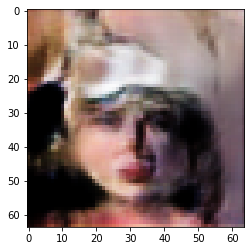


 17%|█▋        | 5/30 [07:37<38:10, 91.61s/it]



Epoch : 5 ---


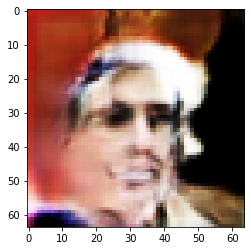

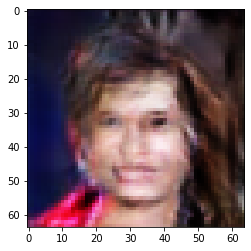

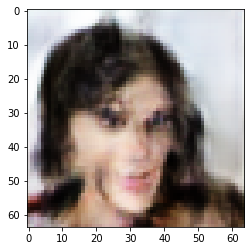


 20%|██        | 6/30 [09:09<36:38, 91.61s/it]



Epoch : 6 ---


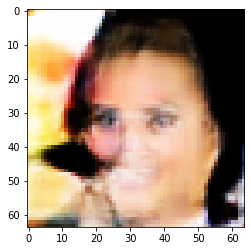

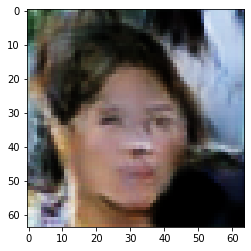

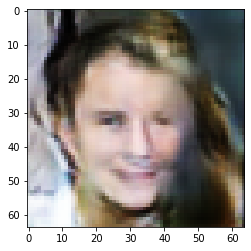


 23%|██▎       | 7/30 [10:41<35:06, 91.58s/it]



Epoch : 7 ---


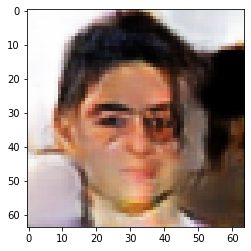

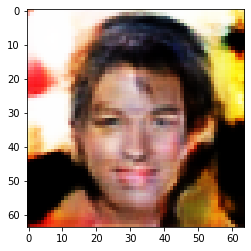

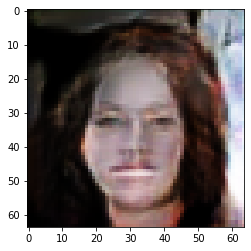


 27%|██▋       | 8/30 [12:12<33:34, 91.58s/it]



Epoch : 8 ---


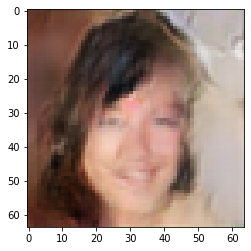

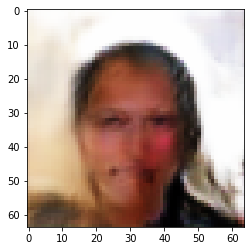

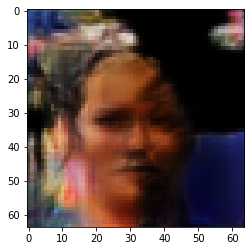


 30%|███       | 9/30 [13:43<32:01, 91.51s/it]



Epoch : 9 ---


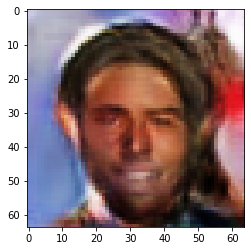

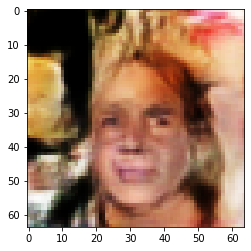

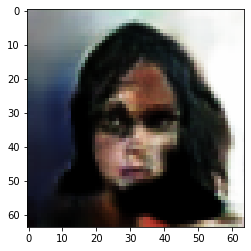


 33%|███▎      | 10/30 [15:15<30:30, 91.52s/it]



Epoch : 10 ---


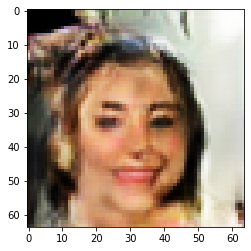

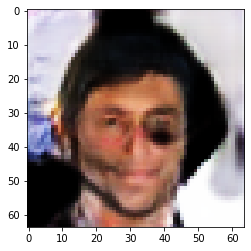

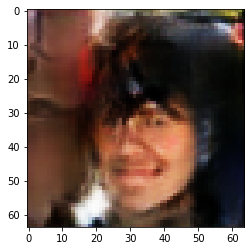


 37%|███▋      | 11/30 [16:46<28:57, 91.43s/it]



Epoch : 11 ---


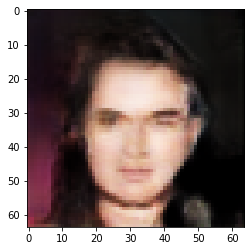

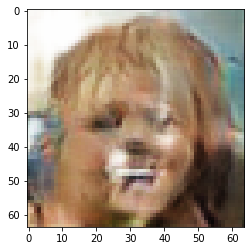

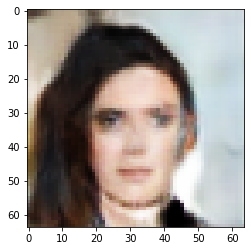


 40%|████      | 12/30 [18:19<27:30, 91.72s/it]



Epoch : 12 ---


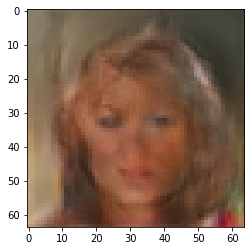

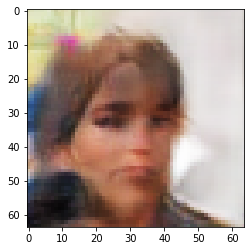

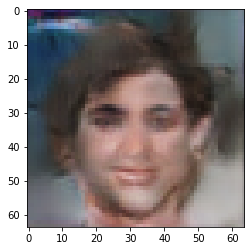


 43%|████▎     | 13/30 [19:52<26:05, 92.11s/it]



Epoch : 13 ---


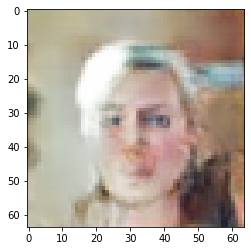

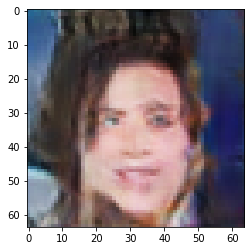

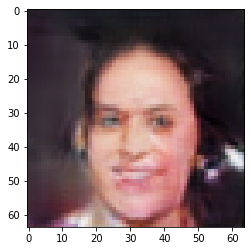


 47%|████▋     | 14/30 [21:23<24:31, 91.99s/it]



Epoch : 14 ---


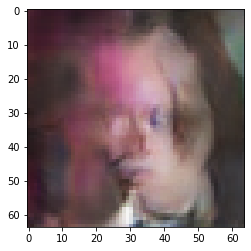

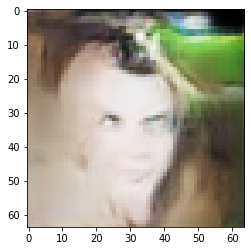

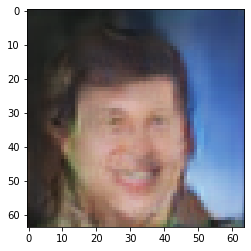


 50%|█████     | 15/30 [22:56<23:01, 92.13s/it]



Epoch : 15 ---


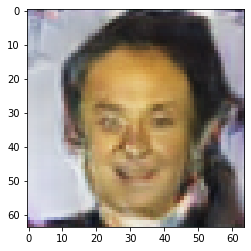

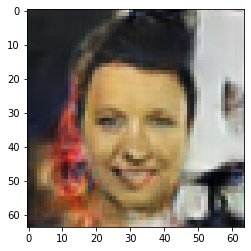

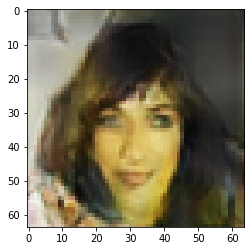


 53%|█████▎    | 16/30 [24:27<21:26, 91.93s/it]



Epoch : 16 ---


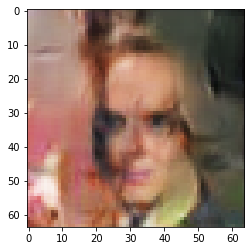

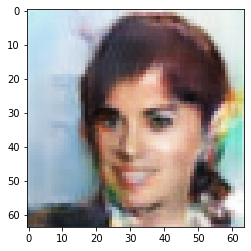

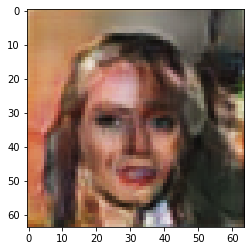


 57%|█████▋    | 17/30 [25:59<19:53, 91.81s/it]



Epoch : 17 ---


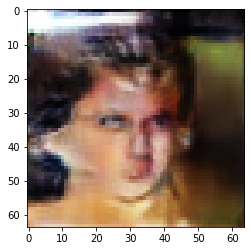

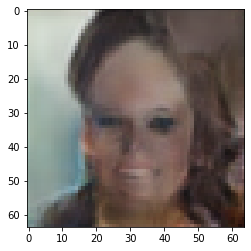

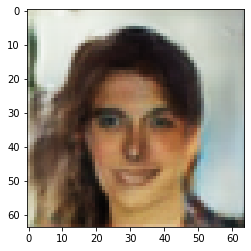


 60%|██████    | 18/30 [27:30<18:21, 91.76s/it]



Epoch : 18 ---


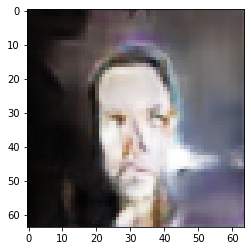

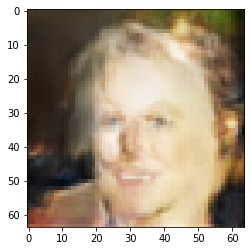

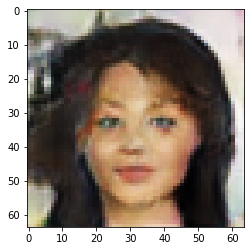


 63%|██████▎   | 19/30 [29:02<16:48, 91.66s/it]



Epoch : 19 ---


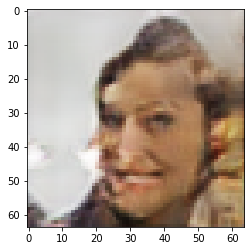

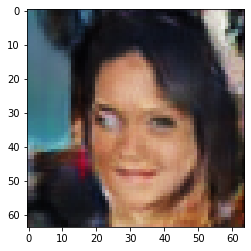

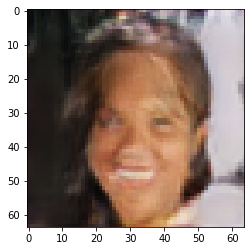


 67%|██████▋   | 20/30 [30:33<15:16, 91.65s/it]



Epoch : 20 ---


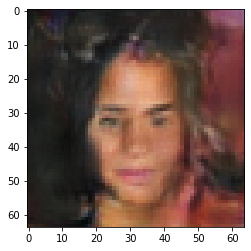

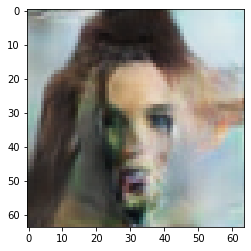

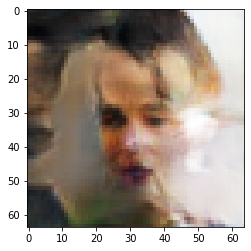


 70%|███████   | 21/30 [32:05<13:45, 91.68s/it]



Epoch : 21 ---


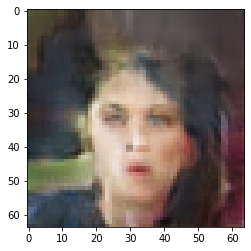

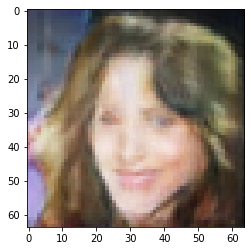

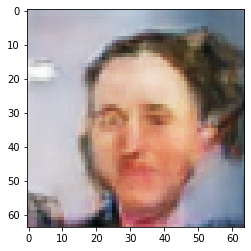


 73%|███████▎  | 22/30 [33:37<12:12, 91.62s/it]



Epoch : 22 ---


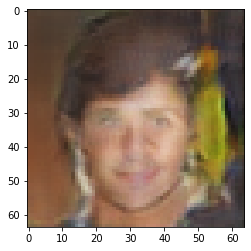

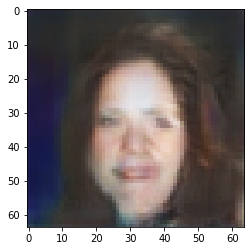

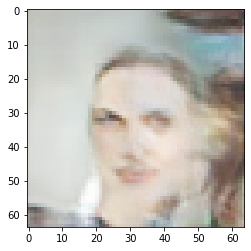


 77%|███████▋  | 23/30 [35:09<10:41, 91.66s/it]



Epoch : 23 ---


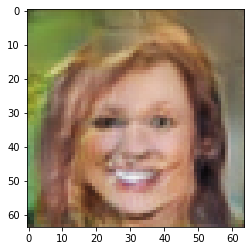

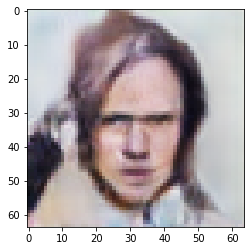

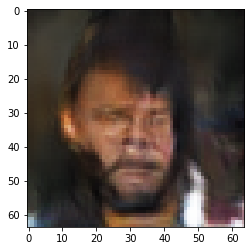


 80%|████████  | 24/30 [36:41<09:10, 91.79s/it]



Epoch : 24 ---


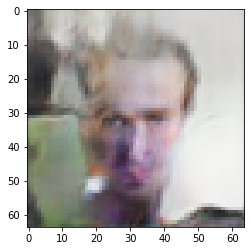

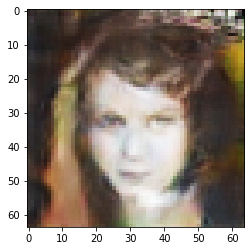

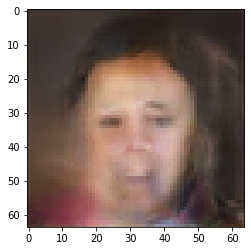


 83%|████████▎ | 25/30 [38:12<07:39, 91.82s/it]



Epoch : 25 ---


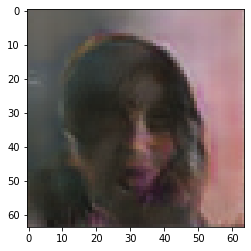

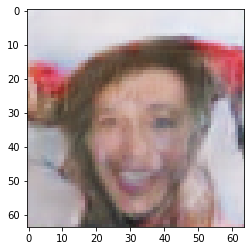

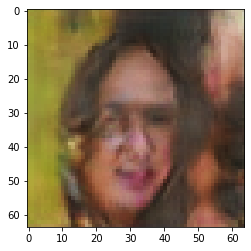


 87%|████████▋ | 26/30 [39:44<06:06, 91.69s/it]



Epoch : 26 ---


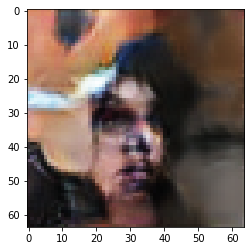

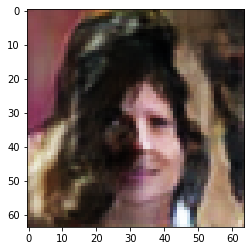

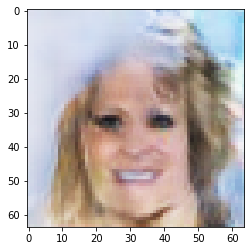


 90%|█████████ | 27/30 [41:16<04:35, 91.68s/it]



Epoch : 27 ---


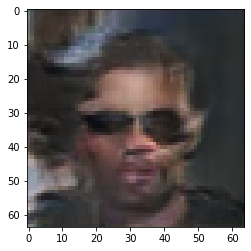

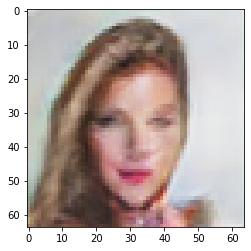

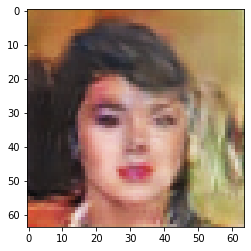


 93%|█████████▎| 28/30 [42:47<03:03, 91.64s/it]



Epoch : 28 ---


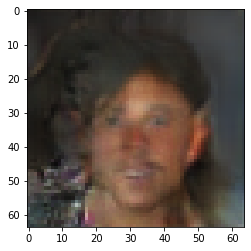

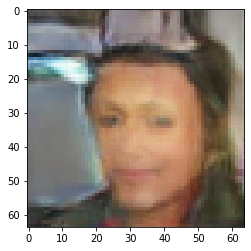

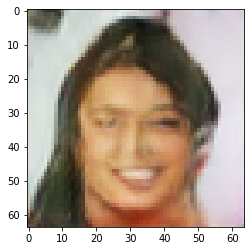


 97%|█████████▋| 29/30 [44:19<01:31, 91.60s/it]



Epoch : 29 ---


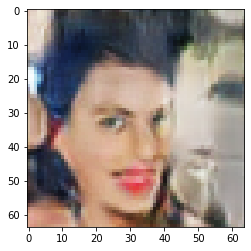

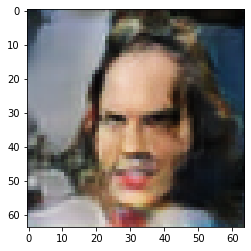

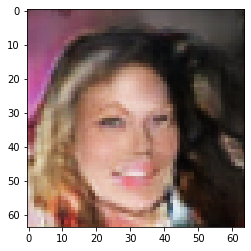


100%|██████████| 30/30 [45:50<00:00, 91.68s/it]


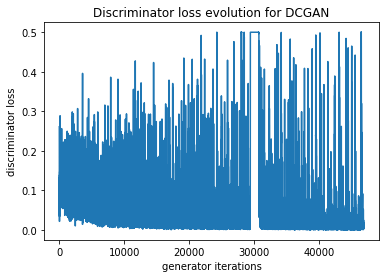

In [ ]:
# Apprentissage
DCGAN_train(train_loader, discriminator, generator, batch_size, nb_epochs, show=True, celeba_data=True)

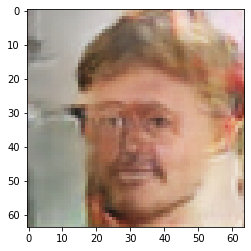

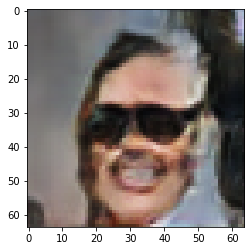

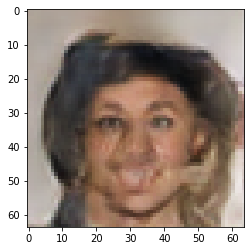

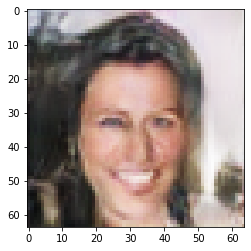

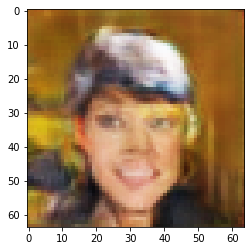

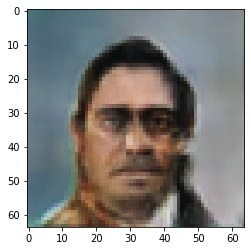

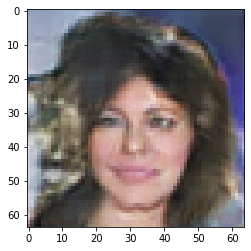

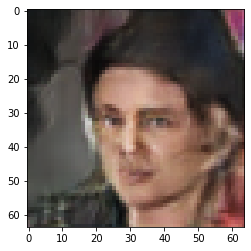

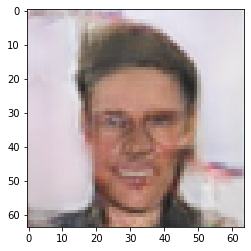

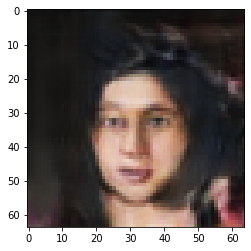

In [ ]:
# Générations de quelques images
generate_and_show(generator, 10, celeba_data=True)

# Wassertein DC-GAN

Dans cette partie nous définissons le modèle Wasserstein DCGAN puis effectuons de la génération d'image sur le jeu de données MNIST.

### Model 

In [ ]:
class W_DCGAN_discriminator(nn.Module):

    def __init__(self, image_depth=1, clip_min=-0.01, clip_max=0.01):

        super(W_DCGAN_discriminator, self).__init__()
        self.clip_min = clip_min
        self.clip_max = clip_max

        self.conv1 = nn.Conv2d(in_channels=image_depth, out_channels=32, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(in_features=4*4*128, out_features=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

    def clip_parameters(self):
        for layer in [self.conv1, self.conv2, self.conv3, self.fc1]:
            layer.weight.data = layer.weight.data.clamp(self.clip_min, self.clip_max)

In [ ]:
def W_discriminator_loss(discriminator, batch_data_real, batch_data_fake):
    first_term = discriminator(batch_data_real).mean() 
    second_term = discriminator(batch_data_fake).mean()
    return - first_term + second_term

def W_generator_loss(discriminator, batch_data_fake):
    return -discriminator(batch_data_fake).mean()

In [ ]:
def W_DCGAN_train(data_loader, discriminator, generator, batch_size, nb_epochs, n_critic=5, show=False):

    optimizer_discriminator = optim.RMSprop(discriminator.parameters(),
                                         lr=0.00005, alpha=0.99) # 0.0002
    optimizer_generator = optim.RMSprop(generator.parameters(),
                                     lr=0.00005, alpha=0.99)
    
    n_iter = 0

    loss_discriminator_list = []

    for epoch in tqdm(range(nb_epochs)):

        for batch_data_real in data_loader:

            n_iter += 1

            batch_data_real = batch_data_real.to(device)

            # Discriminator

            optimizer_discriminator.zero_grad()

            batch_noise_fake = torch.randn(batch_size, 100) * 0.1 
            batch_noise_fake = batch_noise_fake.to(device)
            batch_data_fake = generator.forward(batch_noise_fake)
            loss_discriminator = W_discriminator_loss(discriminator, batch_data_real, 
                                                    batch_data_fake)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            discriminator.clip_parameters()

            # Generator

            if n_iter % n_critic == 0:

                optimizer_generator.zero_grad()
                
                batch_noise_fake = torch.randn(batch_size, 100) * 0.1
                batch_noise_fake = batch_noise_fake.to(device)
                batch_data_fake = generator.forward(batch_noise_fake)
                loss_generator = W_generator_loss(discriminator, batch_data_fake)

                loss_generator.backward()
                optimizer_generator.step()

                loss_discriminator_list.append(loss_discriminator)


        if show:
            print("\n\nEpoch : {} ---".format(epoch))
            generate_and_show(w_dcgan_generator, 3)

    plt.plot(range(1, len(loss_discriminator_list)+1), loss_discriminator_list)
    plt.xlabel("generator iterations")
    plt.ylabel("discriminator loss")
    plt.title("Discriminator loss evolution for Wasserstein GAN")
    plt.show()


### Experiment MNIST

In [ ]:
# Configuration  de l'apprentissage
nb_epochs = 20
batch_size = 32
nb_data_train = 60000
nb_data_test = 1000

In [ ]:
# DataLoader
train_loader_mnist = DataLoader(mnist_data_train[:nb_data_train,:,:,:], batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(mnist_data_test[:nb_data_test,:,:,:], batch_size=batch_size, shuffle=True)

In [ ]:
# Discriminateur
w_dcgan_discriminator = W_DCGAN_discriminator(image_depth=1)
w_dcgan_discriminator.to(device)

# Generateur
w_dcgan_generator = DCGAN_generator(image_depth=1)
w_dcgan_generator.to(device)

DCGAN_generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up3): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up4): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

  0%|          | 0/20 [00:00<?, ?it/s]



Epoch : 0 ---


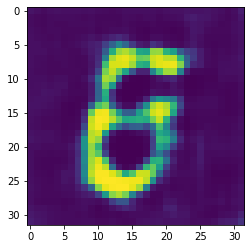

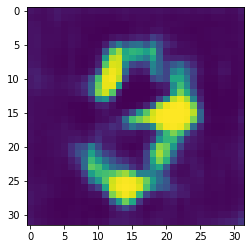

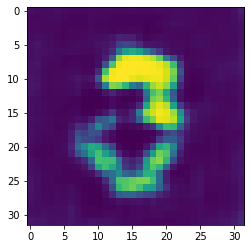

  5%|▌         | 1/20 [00:16<05:14, 16.57s/it]



Epoch : 1 ---


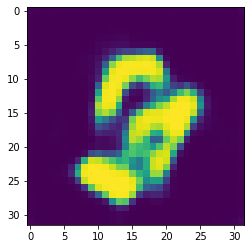

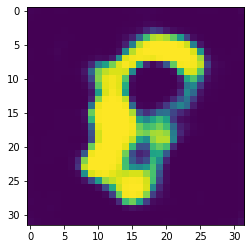

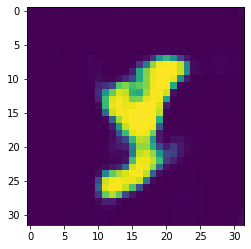

 10%|█         | 2/20 [00:33<04:58, 16.56s/it]



Epoch : 2 ---


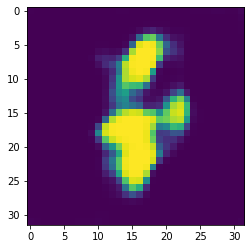

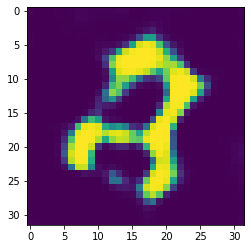

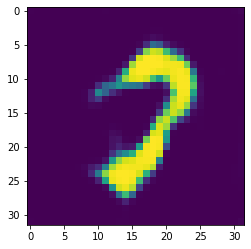

 15%|█▌        | 3/20 [00:49<04:41, 16.58s/it]



Epoch : 3 ---


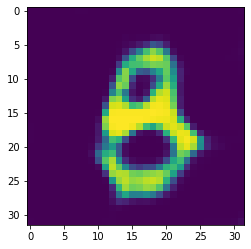

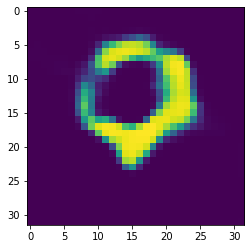

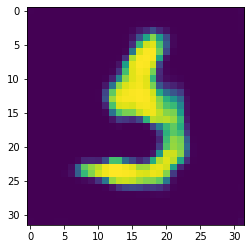

 20%|██        | 4/20 [01:06<04:25, 16.59s/it]



Epoch : 4 ---


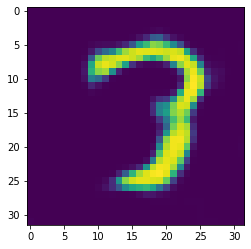

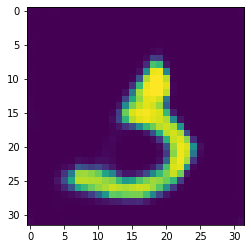

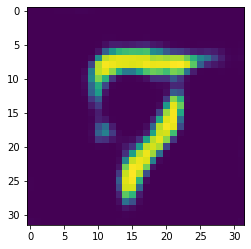

 25%|██▌       | 5/20 [01:22<04:09, 16.60s/it]



Epoch : 5 ---


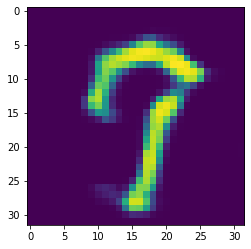

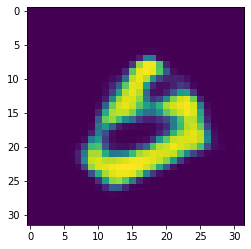

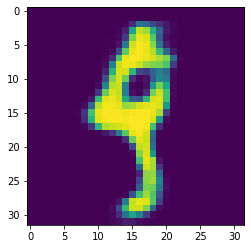

 30%|███       | 6/20 [01:39<03:52, 16.62s/it]



Epoch : 6 ---


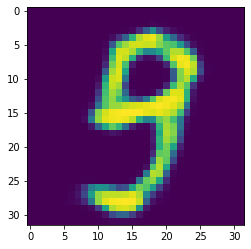

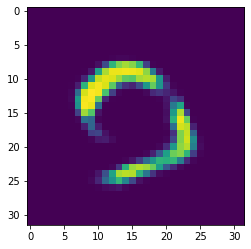

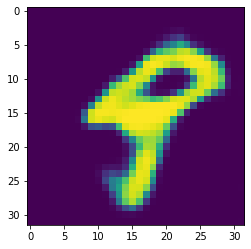

 35%|███▌      | 7/20 [01:56<03:36, 16.63s/it]



Epoch : 7 ---


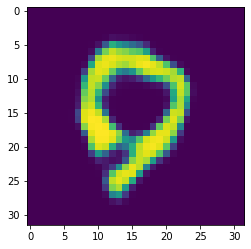

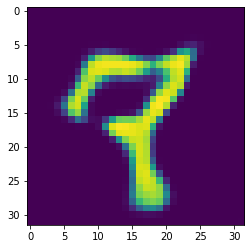

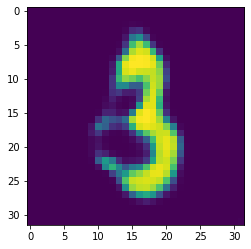

 40%|████      | 8/20 [02:13<03:20, 16.67s/it]



Epoch : 8 ---


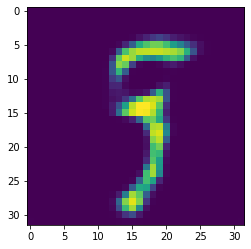

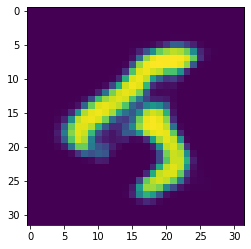

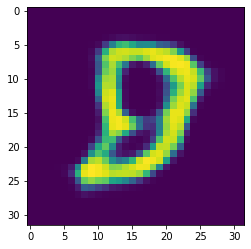

 45%|████▌     | 9/20 [02:29<03:03, 16.68s/it]



Epoch : 9 ---


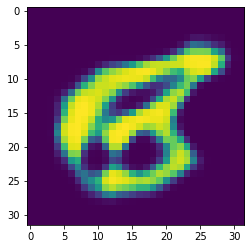

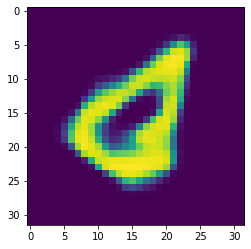

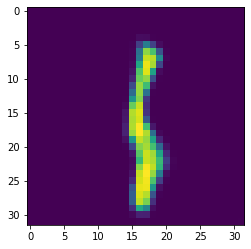

 50%|█████     | 10/20 [02:46<02:47, 16.70s/it]



Epoch : 10 ---


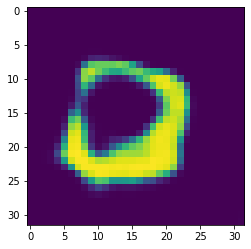

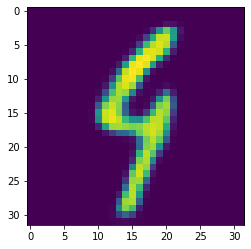

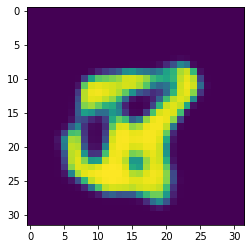

 55%|█████▌    | 11/20 [03:03<02:30, 16.71s/it]



Epoch : 11 ---


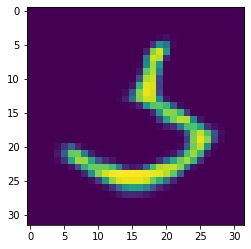

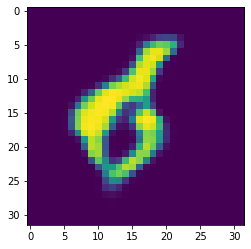

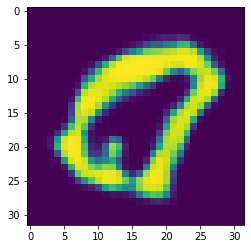

 60%|██████    | 12/20 [03:19<02:13, 16.72s/it]



Epoch : 12 ---


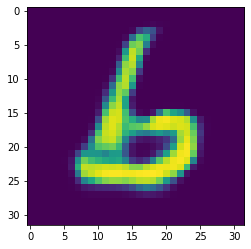

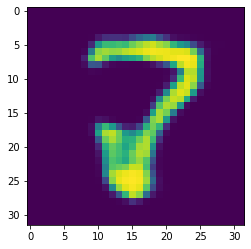

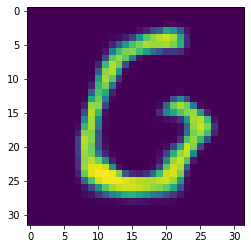

 65%|██████▌   | 13/20 [03:36<01:57, 16.75s/it]



Epoch : 13 ---


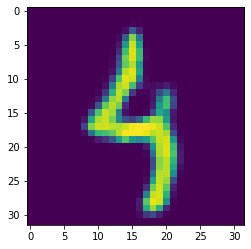

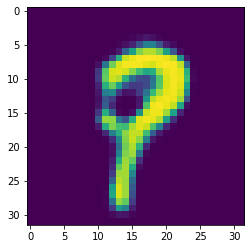

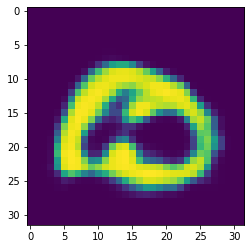

 70%|███████   | 14/20 [03:53<01:40, 16.77s/it]



Epoch : 14 ---


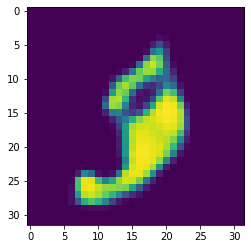

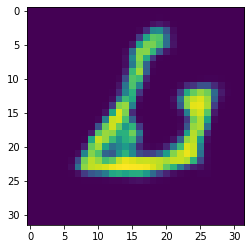

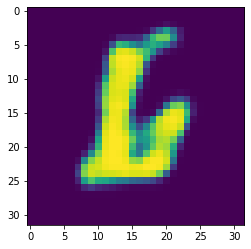

 75%|███████▌  | 15/20 [04:10<01:23, 16.78s/it]



Epoch : 15 ---


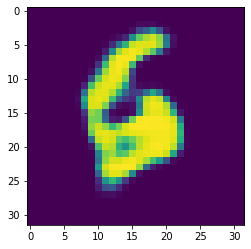

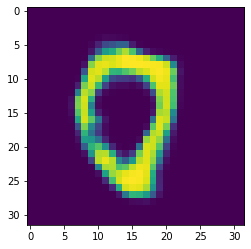

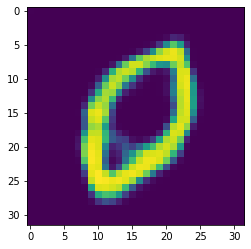

 80%|████████  | 16/20 [04:27<01:07, 16.79s/it]



Epoch : 16 ---


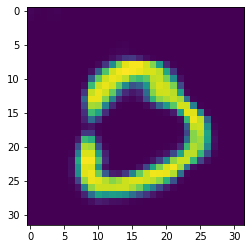

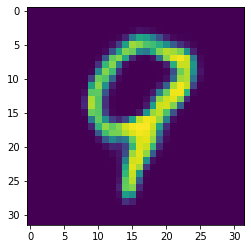

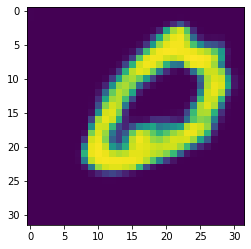

 85%|████████▌ | 17/20 [04:44<00:50, 16.81s/it]



Epoch : 17 ---


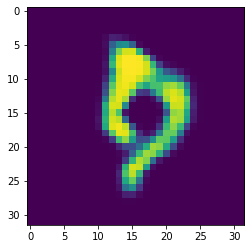

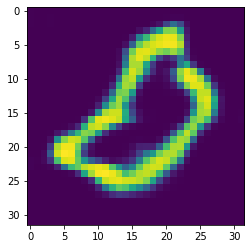

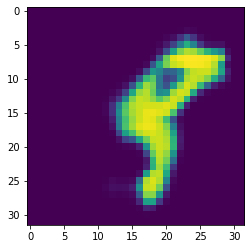

 90%|█████████ | 18/20 [05:00<00:33, 16.80s/it]



Epoch : 18 ---


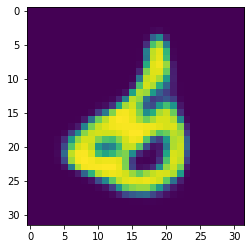

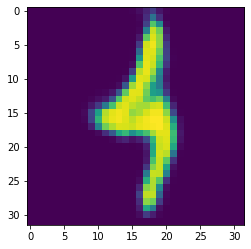

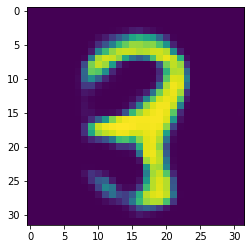

 95%|█████████▌| 19/20 [05:17<00:16, 16.81s/it]



Epoch : 19 ---


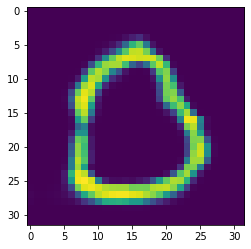

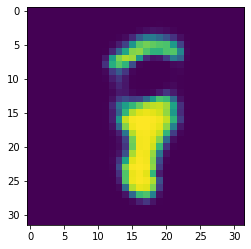

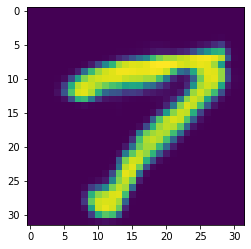

100%|██████████| 20/20 [05:34<00:00, 16.73s/it]


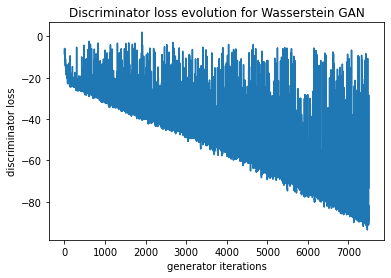

In [ ]:
# Apprentissage
W_DCGAN_train(train_loader_mnist, w_dcgan_discriminator, w_dcgan_generator, batch_size, nb_epochs, show=True)

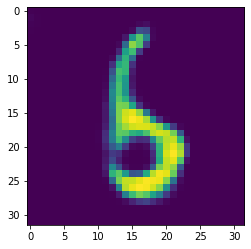

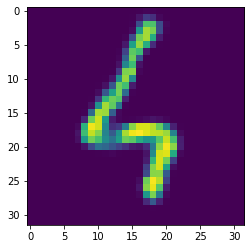

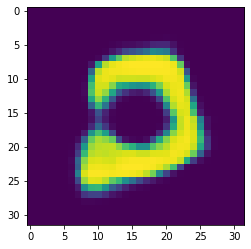

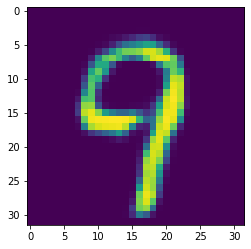

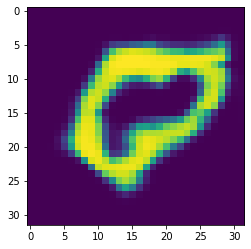

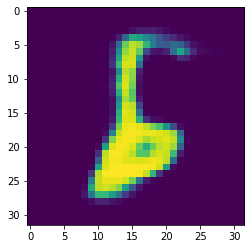

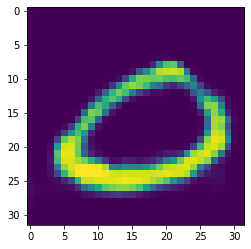

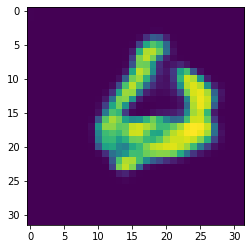

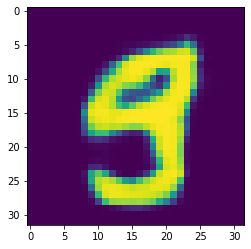

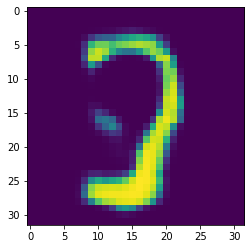

In [ ]:
# Génération d'images
generate_and_show(w_dcgan_generator, 10)

In [ ]:
# Prédictions du discriminateur sur des données réelles
w_dcgan_discriminator(mnist_data_train[:10,:,:,:].to(device))

tensor([[45.5626],
        [40.5003],
        [31.3376],
        [49.4340],
        [44.6114],
        [55.1065],
        [45.2765],
        [51.1816],
        [41.5555],
        [42.9200]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# Prédictions du discriminateur sur des données générées
batch_noise_fake = torch.randn(10, 100) * 0.1
batch_noise_fake = batch_noise_fake.to(device)
batch_data_fake = w_dcgan_generator(batch_noise_fake)
w_dcgan_discriminator(batch_data_fake[:10,:,:,:].to(device))

tensor([[-24.3021],
        [-20.4300],
        [-39.0676],
        [-16.8869],
        [-32.7131],
        [-24.6335],
        [-39.3306],
        [-30.4729],
        [-36.8427],
        [-31.1189]], device='cuda:0', grad_fn=<AddmmBackward>)

# CycleGAN

Dans cette partie nous définissons le modèle Cycle-GAN puis effectuons de la translation d'image sur les jeux de données MNIST et USPS, puis sur le jeu de données CelebA entre personnes aux cheveux noirs et blonds.

### Model

In [ ]:
class CycleGAN_generator(nn.Module):

    def __init__(self, image_depth_in, image_depth_out):

        super(CycleGAN_generator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=image_depth_in, out_channels=32, 
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=5, stride=2, 
                               padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv_res = nn.Conv2d(in_channels=64, out_channels=64, 
                               kernel_size=3, stride=1, 
                               padding=1)

        self.up3 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, 
                               kernel_size=5, stride=1, 
                               padding=2)
        self.bn3 = nn.BatchNorm2d(32)

        self.up4 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=image_depth_out, 
                               kernel_size=5, stride=1,
                               padding=2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = x + self.conv_res(x)

        x = self.up3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.up4(x)
        x = self.conv4(x)
        x = torch.tanh(x)

        return x

In [ ]:
def cycle_discriminator_loss(discriminator, batch_data_real, batch_data_fake):
    first_term = ((discriminator(batch_data_real)-1)**2).mean()
    second_term = (discriminator(batch_data_fake)**2).mean()
    return first_term + second_term

def cycle_generator_loss(discriminator, batch_data_fake, batch_data_real, batch_data_recycled, lambda_cycle):
    raw_generator_loss = ((discriminator(batch_data_fake) - 1)**2).mean()
    cycle_consistency_loss = nn.L1Loss()(batch_data_real, batch_data_recycled)
    return raw_generator_loss + lambda_cycle*cycle_consistency_loss

In [ ]:
class CycleGAN:

    def __init__(self, image_depth_1, image_depth_2, image_size=32):
        self.cycle_generator_1_2 = CycleGAN_generator(image_depth_1, image_depth_2).to(device)
        self.cycle_generator_2_1 = CycleGAN_generator(image_depth_2, image_depth_1).to(device)
        self.discriminator_1 = DCGAN_discriminator(image_depth_1, image_size=image_size).to(device)
        self.discriminator_2 = DCGAN_discriminator(image_depth_2, image_size=image_size).to(device)

    def train(self, data_loader_1, data_loader_2, nb_epochs, lambda_cycle=0.1, show=False, celeba_data=False):

        optimizer_discriminator_1 = optim.Adam(self.discriminator_1.parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999))
        optimizer_discriminator_2 = optim.Adam(self.discriminator_2.parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999))
        optimizer_generator_1_2 = optim.Adam(self.cycle_generator_1_2.parameters(),
                                     lr=0.0002, betas=(0.5, 0.999))
        optimizer_generator_2_1 = optim.Adam(self.cycle_generator_2_1.parameters(),
                                     lr=0.0002, betas=(0.5, 0.999))
    
        for epoch in tqdm(range(nb_epochs)):

            if show:
                print("\n\nEpoch : {} ---".format(epoch))
                #TO ADAPT TO GET DATA TRAIN FROM DATA LOADER
                self.generate_1_2_and_show(mnist_data_train[:4,:,:,:])  #####################################

            for batch_data_real_1, batch_data_real_2 in zip(data_loader_1, data_loader_2):

                if celeba_data:
                    batch_data_real_1 = 2*batch_data_real_1[0] - 1
                    batch_data_real_2 = 2*batch_data_real_2[0] - 1

                batch_data_real_1 = batch_data_real_1.to(device)
                batch_data_real_2 = batch_data_real_2.to(device)

                # Discriminator 1
                
                optimizer_discriminator_1.zero_grad()

                batch_data_fake_1 = self.cycle_generator_2_1(batch_data_real_2)

                loss_discriminator_1 = cycle_discriminator_loss(self.discriminator_1, batch_data_real_1, 
                                                        batch_data_fake_1)
                loss_discriminator_1.backward()
                optimizer_discriminator_1.step()
                
                # Discriminator 2

                optimizer_discriminator_2.zero_grad()

                batch_data_fake_2 = self.cycle_generator_1_2(batch_data_real_1)

                loss_discriminator_2 = cycle_discriminator_loss(self.discriminator_2, batch_data_real_2, 
                                                        batch_data_fake_2)
                loss_discriminator_2.backward()
                optimizer_discriminator_2.step()

                # Generator 1 -> 2

                optimizer_generator_1_2.zero_grad()

                batch_data_fake_2 = self.cycle_generator_1_2(batch_data_real_1)

                batch_data_recycled_1 = self.cycle_generator_2_1(batch_data_fake_2)

                loss_generator_1_2 = cycle_generator_loss(self.discriminator_2, batch_data_fake_2, batch_data_real_1, batch_data_recycled_1, lambda_cycle)

                loss_generator_1_2.backward()
                optimizer_generator_1_2.step()

                # Generator 2 -> 1

                optimizer_generator_2_1.zero_grad()

                batch_data_fake_1 = self.cycle_generator_2_1(batch_data_real_2)

                batch_data_recycled_2 = self.cycle_generator_1_2(batch_data_fake_1)

                loss_generator_2_1 = cycle_generator_loss(self.discriminator_1, batch_data_fake_1, batch_data_real_2, batch_data_recycled_2, lambda_cycle)

                loss_generator_2_1.backward()
                optimizer_generator_2_1.step()

    def generate_1_2_and_show(self, batch_data_real):
            batch_data_fake = self.cycle_generator_1_2(batch_data_real.to(device))
            for data_real, data_fake in zip(batch_data_real, batch_data_fake):
                plt.imshow(data_real.view(32,32).cpu().detach().numpy())
                plt.show()
                plt.imshow(data_fake.view(32,32).cpu().detach().numpy())
                plt.show()
                print("---------------------------")

    def generate_2_1_and_show(self, batch_data_real):
            batch_data_fake = self.cycle_generator_2_1(batch_data_real.to(device))
            for data_real, data_fake in zip(batch_data_real, batch_data_fake):
                plt.imshow(data_real.view(32,32).cpu().detach().numpy())
                plt.show()
                plt.imshow(data_fake.view(32,32).cpu().detach().numpy())
                plt.show()
                print("---------------------------")

### Experiment MNIST to USPS

In [ ]:
# Configuration de l'apprentissage
nb_epochs = 5
batch_size = 16
nb_data_train = 7000
nb_data_test = 500

In [ ]:
# DataLoader
train_loader_mnist = DataLoader(mnist_data_train[:nb_data_train,:,:,:], batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(mnist_data_test[:nb_data_test,:,:,:], batch_size=batch_size, shuffle=True)

train_usps_loader = DataLoader(usps_data_train[:nb_data_train,:,:,:], batch_size=batch_size, shuffle=True)
test_usps_loader = DataLoader(usps_data_test[:nb_data_test,:,:,:], batch_size=batch_size, shuffle=True)

In [ ]:
# Modèle
cycleGAN = CycleGAN(1, 1)

  0%|          | 0/5 [00:00<?, ?it/s]



Epoch : 0 ---


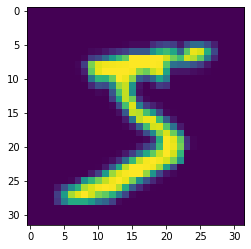

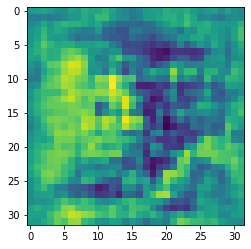

---------------------------


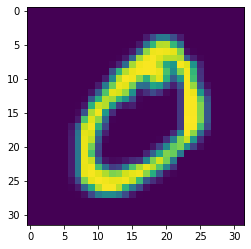

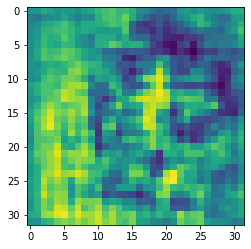

---------------------------


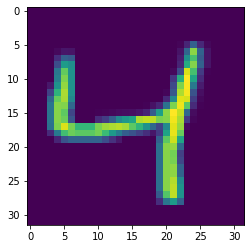

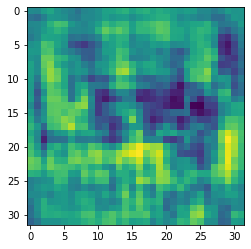

---------------------------


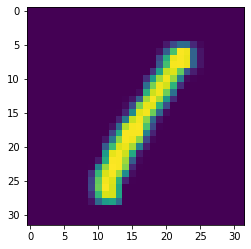

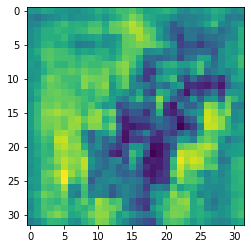

---------------------------


 20%|██        | 1/5 [00:10<00:43, 10.90s/it]



Epoch : 1 ---


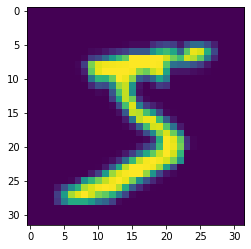

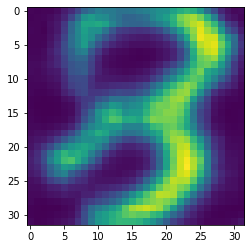

---------------------------


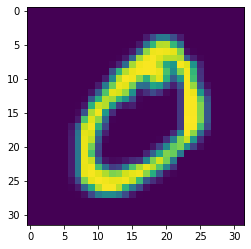

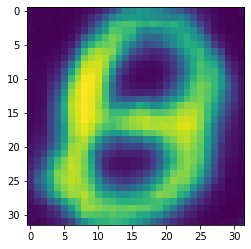

---------------------------


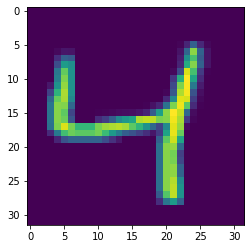

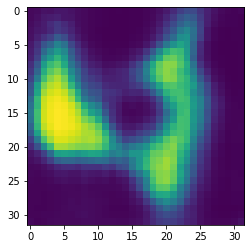

---------------------------


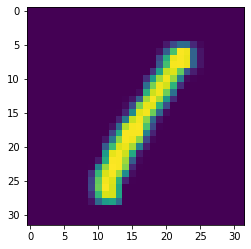

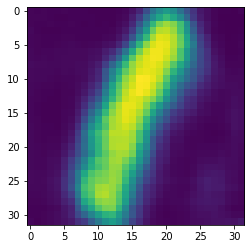

---------------------------


 40%|████      | 2/5 [00:21<00:32, 10.91s/it]



Epoch : 2 ---


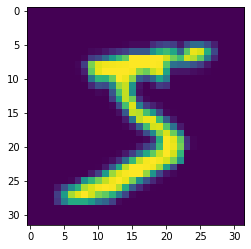

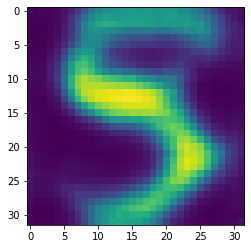

---------------------------


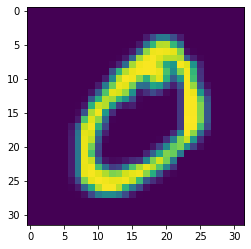

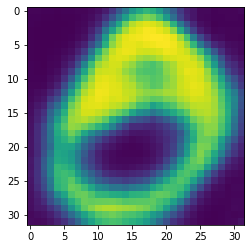

---------------------------


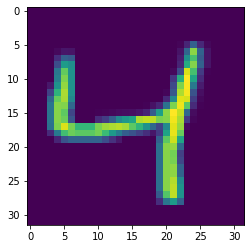

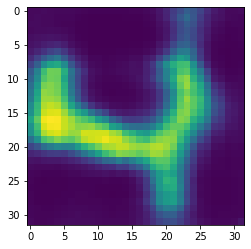

---------------------------


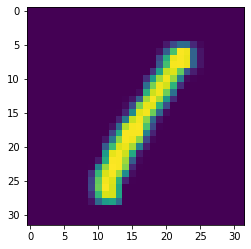

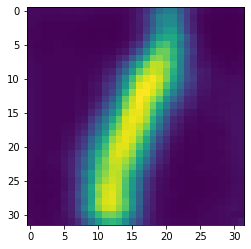

---------------------------


 60%|██████    | 3/5 [00:32<00:21, 10.90s/it]



Epoch : 3 ---


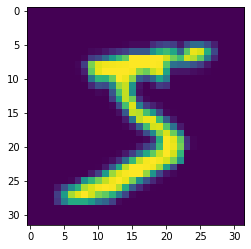

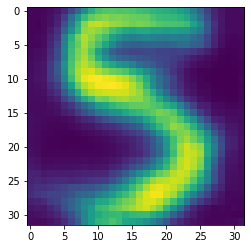

---------------------------


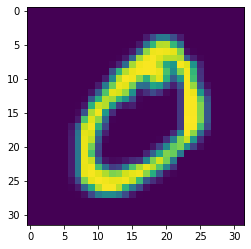

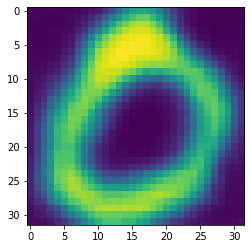

---------------------------


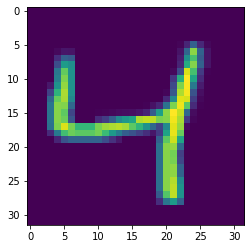

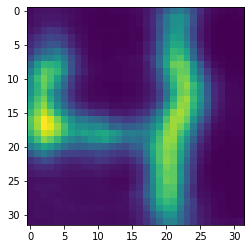

---------------------------


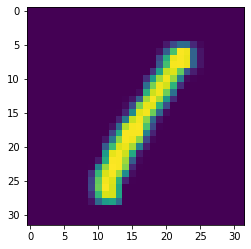

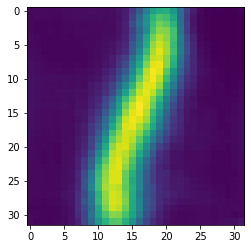

---------------------------


 80%|████████  | 4/5 [00:43<00:10, 10.91s/it]



Epoch : 4 ---


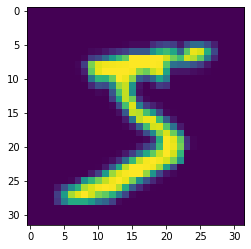

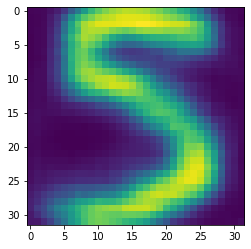

---------------------------


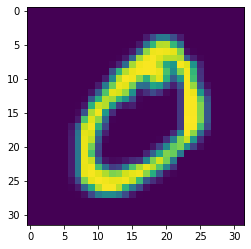

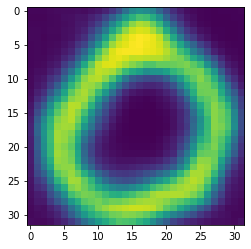

---------------------------


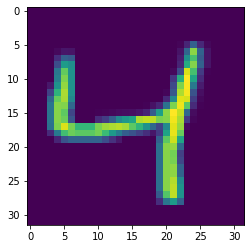

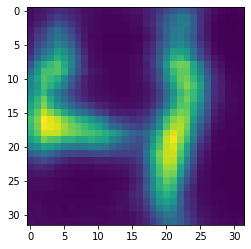

---------------------------


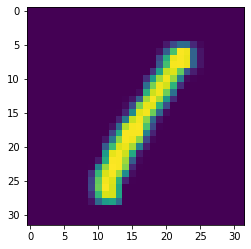

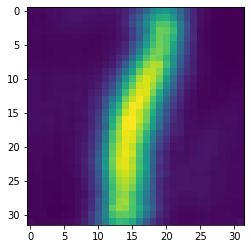

---------------------------


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


In [ ]:
# Apprentissage
cycleGAN.train(data_loader_1=train_loader_mnist, data_loader_2=train_usps_loader, nb_epochs=nb_epochs, show=True)

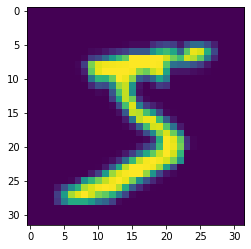

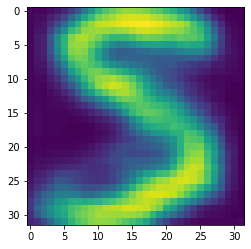

---------------------------


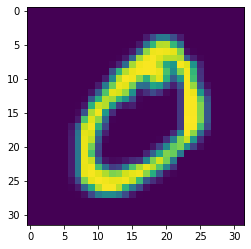

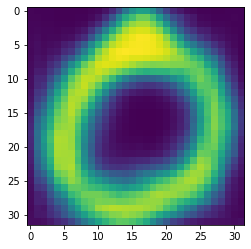

---------------------------


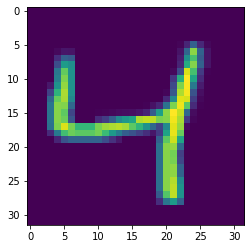

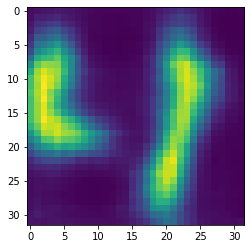

---------------------------


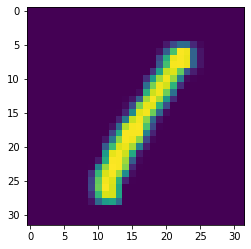

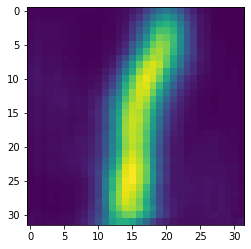

---------------------------


In [ ]:
# MNIST vers USPS
cycleGAN.generate_1_2_and_show(mnist_data_train[:4,:,:,:])

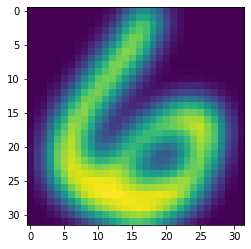

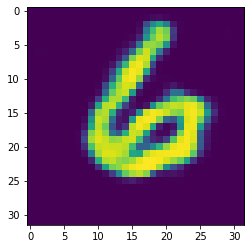

---------------------------


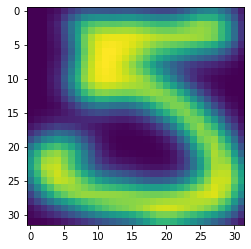

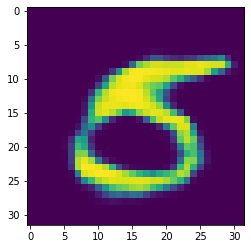

---------------------------


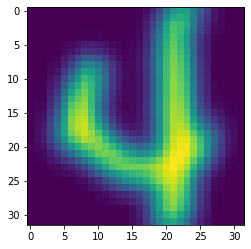

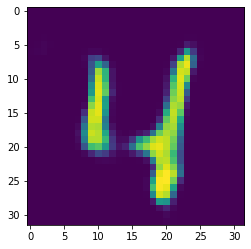

---------------------------


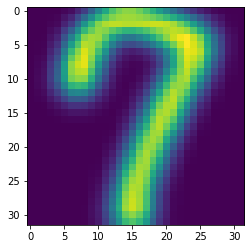

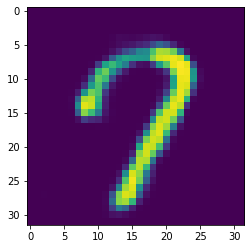

---------------------------


In [ ]:
# USPS vers MNIST
cycleGAN.generate_2_1_and_show(usps_data_train[:4,:,:,:])

### Experiment CelebA Blond Hair to Black hair

In [ ]:
# Configuration de l'apprentissage
nb_epochs = 30
batch_size = 32

In [ ]:
# DataLoader
train_loader_black_hair= DataLoader(dataset_black_hair, batch_size=batch_size, shuffle=True)
train_loader_blond_hair = DataLoader(dataset_blond_hair, batch_size=batch_size, shuffle=True)

In [ ]:
# Modèle
cycleGAN = CycleGAN(3, 3, image_size=64)

In [ ]:
# Apprentissage
cycleGAN.train(data_loader_1=train_loader_blond_hair, data_loader_2=train_loader_black_hair, nb_epochs=nb_epochs, show=False, celeba_data=True)


100%|██████████| 30/30 [08:08<00:00, 16.27s/it]


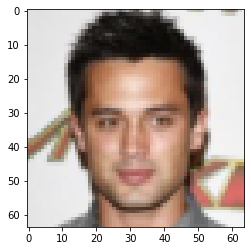

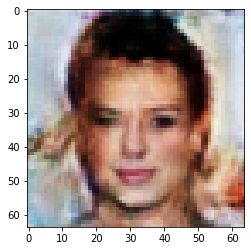

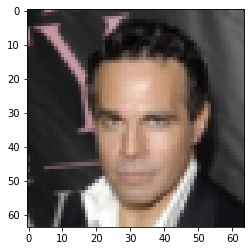

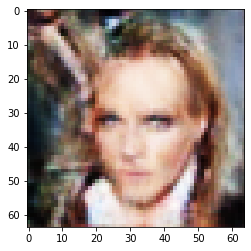

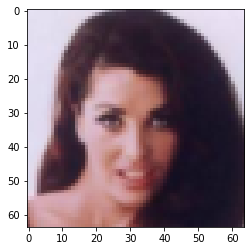

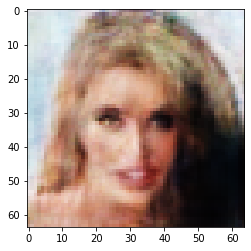

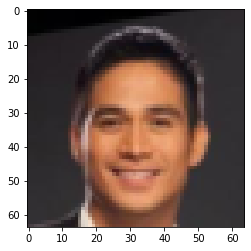

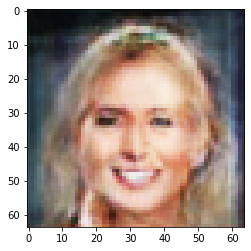

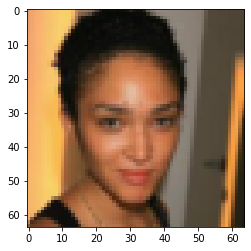

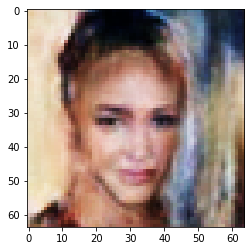

In [ ]:
# Transfert black_hair vers blond_hair
for i in range(5):
    plt.imshow(dataset_black_hair[i][0].permute(1,2,0))
    plt.show()

    data_to_cycle = (2*dataset_black_hair[i][0]-1).unsqueeze(0)

    batch_data_fake = (cycleGAN.cycle_generator_2_1(data_to_cycle.to(device))+1)/2

    plt.imshow(batch_data_fake.squeeze(0).permute(1,2,0).cpu().detach().numpy())
    plt.show()

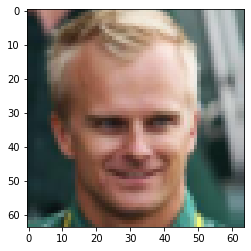

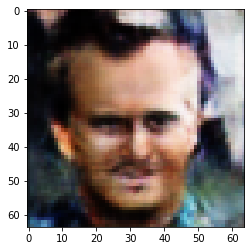

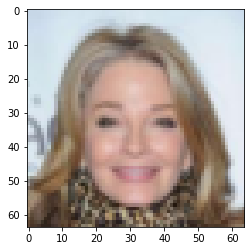

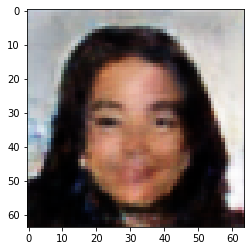

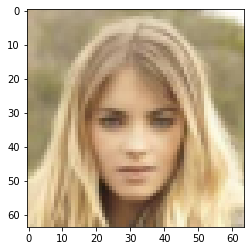

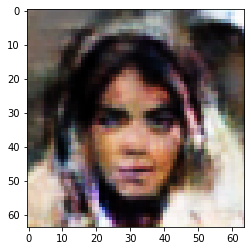

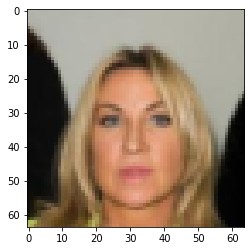

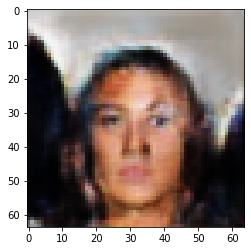

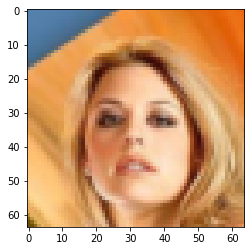

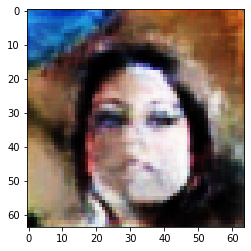

In [ ]:
# transfert blond_hair vers black_hair
for i in range(5):
    plt.imshow(dataset_blond_hair[i][0].permute(1,2,0))
    plt.show()

    data_to_cycle = (2*dataset_blond_hair[i][0]-1).unsqueeze(0)

    batch_data_fake = (cycleGAN.cycle_generator_1_2(data_to_cycle.to(device))+1)/2

    plt.imshow(batch_data_fake.squeeze(0).permute(1,2,0).cpu().detach().numpy())
    plt.show()